# Advanced Feature Engineering

This notebook demonstrates advanced techniques in feature engineering for machine learning projects. We'll cover:

1. **Dealing with Dirty Data** - Handling inconsistencies, outliers, and data quality issues
2. **Feature Value Imputation** - Techniques to fill missing values
3. **Engineered Features** - Creating new features from existing ones
4. **Denoising With ML Models** - Using machine learning to clean and denoise data

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Dealing with Dirty Data

Real-world data is often messy. Let's explore common issues and how to handle them:

- Inconsistent formatting
- Duplicate records
- Outliers
- Invalid values
- Data type mismatches

In [3]:
# Create a sample dirty dataset
dirty_data = pd.DataFrame({
    'customer_id': [1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'age': [25, 35, 35, -5, 150, 28, 42, 31, 29, 38, 45],
    'income': [50000, 75000, 75000, 60000, 1000000, 55000, 80000, 62000, 58000, 70000, 85000],
    'email': ['john@email.com', 'JANE@EMAIL.COM', 'jane@email.com', 'bob@email.com', 
              'alice@email.com', 'charlie@email.com', 'david@email.com', 'eve@email.com',
              'frank@email.com', 'grace@email.com', 'henry@email.com'],
    'zip_code': ['12345', '23456', '23456', '34567', '45678', '56789', '67890', '78901', '89012', '90123', '01234']
})

print("Original Dirty Data:")
print(dirty_data)
print(f"\nShape: {dirty_data.shape}")

Original Dirty Data:
    customer_id  age   income              email zip_code
0             1   25    50000     john@email.com    12345
1             2   35    75000     JANE@EMAIL.COM    23456
2             2   35    75000     jane@email.com    23456
3             3   -5    60000      bob@email.com    34567
4             4  150  1000000    alice@email.com    45678
5             5   28    55000  charlie@email.com    56789
6             6   42    80000    david@email.com    67890
7             7   31    62000      eve@email.com    78901
8             8   29    58000    frank@email.com    89012
9             9   38    70000    grace@email.com    90123
10           10   45    85000    henry@email.com    01234

Shape: (11, 5)


### 1.1 Handling Duplicates

In [8]:
# Identify and remove duplicates
print(f"Duplicate rows: {dirty_data.duplicated().sum()}")

# Remove duplicates based on customer_id
clean_data = dirty_data.drop_duplicates(subset=['customer_id'], keep='first').copy()
print(f"\nAfter removing duplicates: {clean_data.shape}")
print(clean_data)

Duplicate rows: 0

After removing duplicates: (10, 5)
    customer_id  age   income              email zip_code
0             1   25    50000     john@email.com    12345
1             2   35    75000     JANE@EMAIL.COM    23456
3             3   -5    60000      bob@email.com    34567
4             4  150  1000000    alice@email.com    45678
5             5   28    55000  charlie@email.com    56789
6             6   42    80000    david@email.com    67890
7             7   31    62000      eve@email.com    78901
8             8   29    58000    frank@email.com    89012
9             9   38    70000    grace@email.com    90123
10           10   45    85000    henry@email.com    01234


### 1.2 Standardizing Text Data

In [9]:
# Standardize email addresses to lowercase
clean_data['email'] = clean_data['email'].str.lower()
print("Standardized email addresses:")
print(clean_data['email'])

Standardized email addresses:
0        john@email.com
1        jane@email.com
3         bob@email.com
4       alice@email.com
5     charlie@email.com
6       david@email.com
7         eve@email.com
8       frank@email.com
9       grace@email.com
10      henry@email.com
Name: email, dtype: object


### 1.3 Detecting and Handling Outliers

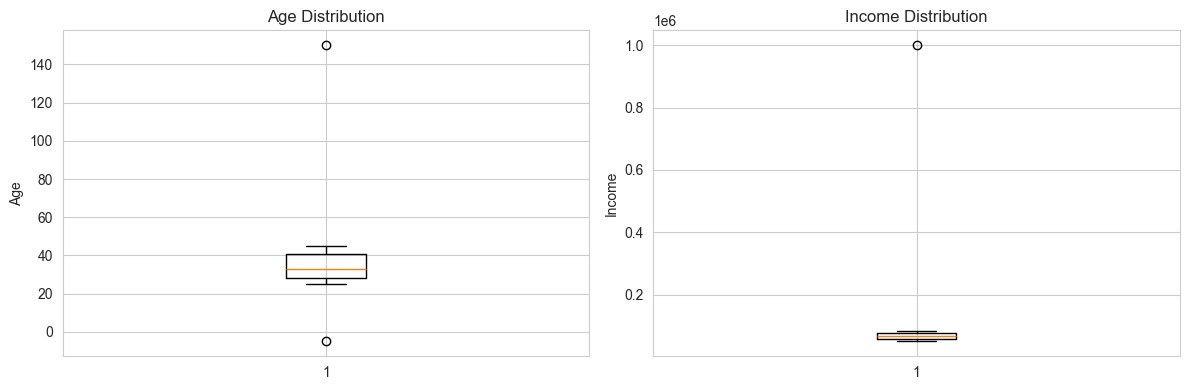


Age statistics:
count     10.0000
mean      41.8000
std       40.4442
min       -5.0000
25%       28.2500
50%       33.0000
75%       41.0000
max      150.0000
Name: age, dtype: float64


In [10]:
# Visualize potential outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].boxplot(clean_data['age'].dropna())
axes[0].set_title('Age Distribution')
axes[0].set_ylabel('Age')

axes[1].boxplot(clean_data['income'].dropna())
axes[1].set_title('Income Distribution')
axes[1].set_ylabel('Income')

plt.tight_layout()
plt.show()

print("\nAge statistics:")
print(clean_data['age'].describe())

In [11]:
# Method 1: Remove outliers using IQR (Interquartile Range)
def remove_outliers_iqr(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Method 2: Cap outliers at percentiles
def cap_outliers(df, column, lower_percentile=5, upper_percentile=95):
    lower_cap = df[column].quantile(lower_percentile/100)
    upper_cap = df[column].quantile(upper_percentile/100)
    df[column] = df[column].clip(lower=lower_cap, upper=upper_cap)
    return df

# Method 3: Isolation Forest for multivariate outliers
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_predictions = iso_forest.fit_predict(clean_data[['age', 'income']])

print(f"Outliers detected by Isolation Forest: {(outlier_predictions == -1).sum()}")

# Apply domain knowledge to fix obvious errors
clean_data.loc[clean_data['age'] < 0, 'age'] = np.nan
clean_data.loc[clean_data['age'] > 120, 'age'] = np.nan

print("\nData after handling invalid age values:")
print(clean_data)

Outliers detected by Isolation Forest: 1

Data after handling invalid age values:
    customer_id   age   income              email zip_code
0             1  25.0    50000     john@email.com    12345
1             2  35.0    75000     jane@email.com    23456
3             3   NaN    60000      bob@email.com    34567
4             4   NaN  1000000    alice@email.com    45678
5             5  28.0    55000  charlie@email.com    56789
6             6  42.0    80000    david@email.com    67890
7             7  31.0    62000      eve@email.com    78901
8             8  29.0    58000    frank@email.com    89012
9             9  38.0    70000    grace@email.com    90123
10           10  45.0    85000    henry@email.com    01234


## 2. Feature Value Imputation

Missing values are common in real-world datasets. Let's explore various imputation techniques:

- Simple imputation (mean, median, mode)
- K-Nearest Neighbors imputation
- Iterative imputation
- Forward fill / backward fill for time series

In [12]:
# Create a dataset with missing values
np.random.seed(42)
n_samples = 100

data_with_missing = pd.DataFrame({
    'feature_1': np.random.randn(n_samples),
    'feature_2': np.random.randn(n_samples) * 10 + 50,
    'feature_3': np.random.randint(1, 100, n_samples),
    'feature_4': np.random.randn(n_samples) * 5 + 25,
    'category': np.random.choice(['A', 'B', 'C'], n_samples)
})

# Introduce missing values randomly
missing_mask = np.random.random(data_with_missing.shape) < 0.15
data_with_missing_copy = data_with_missing.copy()
data_with_missing_copy = data_with_missing_copy.mask(missing_mask)

print("Missing values per column:")
print(data_with_missing_copy.isnull().sum())
print(f"\nTotal missing values: {data_with_missing_copy.isnull().sum().sum()}")
print(f"Percentage missing: {data_with_missing_copy.isnull().sum().sum() / data_with_missing_copy.size * 100:.2f}%")

Missing values per column:
feature_1    15
feature_2    14
feature_3    10
feature_4    17
category     18
dtype: int64

Total missing values: 74
Percentage missing: 14.80%


### 2.1 Simple Imputation Strategies

In [13]:
# Mean imputation for numerical features
mean_imputer = SimpleImputer(strategy='mean')
data_mean_imputed = data_with_missing_copy.copy()
numeric_cols = data_mean_imputed.select_dtypes(include=[np.number]).columns
data_mean_imputed[numeric_cols] = mean_imputer.fit_transform(data_mean_imputed[numeric_cols])

print("Mean Imputation Results:")
print(f"Remaining missing values: {data_mean_imputed.isnull().sum().sum()}")

# Median imputation (more robust to outliers)
median_imputer = SimpleImputer(strategy='median')
data_median_imputed = data_with_missing_copy.copy()
data_median_imputed[numeric_cols] = median_imputer.fit_transform(data_median_imputed[numeric_cols])

print("\nMedian Imputation Results:")
print(f"Remaining missing values: {data_median_imputed.isnull().sum().sum()}")

# Most frequent (mode) imputation for categorical features
mode_imputer = SimpleImputer(strategy='most_frequent')
data_mode_imputed = data_with_missing_copy.copy()
data_mode_imputed['category'] = mode_imputer.fit_transform(data_mode_imputed[['category']])

print("\nMode Imputation for Category:")
print(f"Remaining missing values in category: {data_mode_imputed['category'].isnull().sum()}")

Mean Imputation Results:
Remaining missing values: 18

Median Imputation Results:
Remaining missing values: 18


ValueError: 2

### 2.2 KNN Imputation

KNN Imputation Results:
Remaining missing values: 0


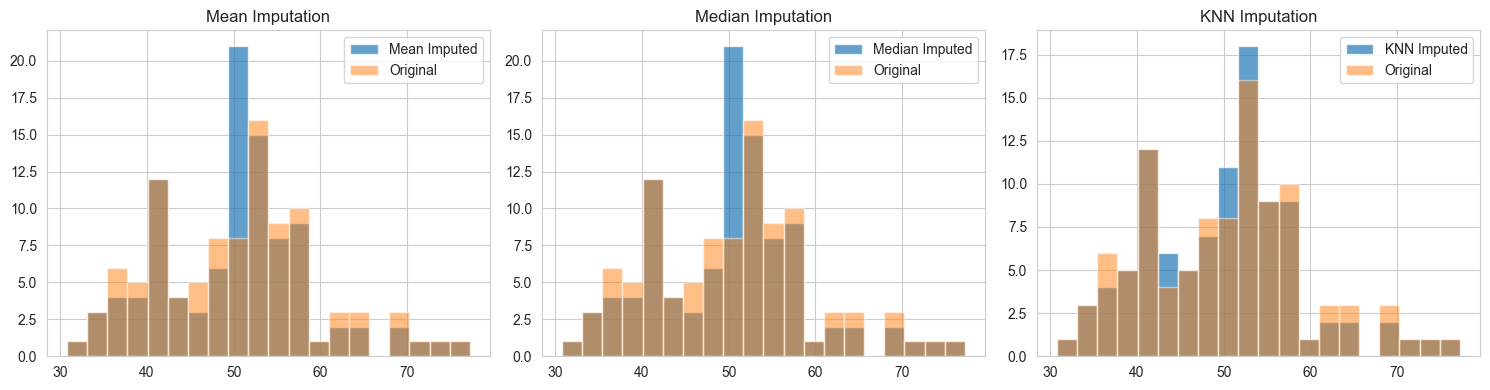

In [14]:
# KNN Imputation - uses k nearest neighbors to estimate missing values
knn_imputer = KNNImputer(n_neighbors=5)
data_knn_imputed = data_with_missing_copy.copy()
data_knn_imputed[numeric_cols] = knn_imputer.fit_transform(data_knn_imputed[numeric_cols])

print("KNN Imputation Results:")
print(f"Remaining missing values: {data_knn_imputed[numeric_cols].isnull().sum().sum()}")

# Compare different imputation methods
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(data_mean_imputed['feature_2'], bins=20, alpha=0.7, label='Mean Imputed')
axes[0].hist(data_with_missing['feature_2'], bins=20, alpha=0.5, label='Original')
axes[0].set_title('Mean Imputation')
axes[0].legend()

axes[1].hist(data_median_imputed['feature_2'], bins=20, alpha=0.7, label='Median Imputed')
axes[1].hist(data_with_missing['feature_2'], bins=20, alpha=0.5, label='Original')
axes[1].set_title('Median Imputation')
axes[1].legend()

axes[2].hist(data_knn_imputed['feature_2'], bins=20, alpha=0.7, label='KNN Imputed')
axes[2].hist(data_with_missing['feature_2'], bins=20, alpha=0.5, label='Original')
axes[2].set_title('KNN Imputation')
axes[2].legend()

plt.tight_layout()
plt.show()

### 2.3 Advanced Imputation: Using ML Model Predictions

In [15]:
# Use a Random Forest to predict missing values
def ml_imputation(df, target_col, feature_cols):
    """Impute missing values using a Random Forest model"""
    df_copy = df.copy()
    
    # Split into rows with and without missing values
    train_data = df_copy[df_copy[target_col].notna()]
    predict_data = df_copy[df_copy[target_col].isna()]
    
    if len(predict_data) == 0:
        return df_copy
    
    # Train Random Forest on complete cases
    X_train = train_data[feature_cols].fillna(train_data[feature_cols].mean())
    y_train = train_data[target_col]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict missing values
    X_predict = predict_data[feature_cols].fillna(train_data[feature_cols].mean())
    predictions = model.predict(X_predict)
    
    # Fill in the predictions
    df_copy.loc[df_copy[target_col].isna(), target_col] = predictions
    
    return df_copy

# Apply ML imputation to feature_2
data_ml_imputed = ml_imputation(
    data_with_missing_copy, 
    target_col='feature_2', 
    feature_cols=['feature_1', 'feature_3', 'feature_4']
)

print("ML-based Imputation Results:")
print(f"Remaining missing values in feature_2: {data_ml_imputed['feature_2'].isnull().sum()}")

ML-based Imputation Results:
Remaining missing values in feature_2: 0


## 3. Engineered Features

Feature engineering is the process of creating new features from existing ones to improve model performance:

- Polynomial features
- Interaction features
- Aggregation features
- Domain-specific features
- Time-based features

In [17]:
# Create a sample dataset for feature engineering
np.random.seed(42)
n = 200

engineering_data = pd.DataFrame({
    'temperature': np.random.uniform(15, 35, n),
    'humidity': np.random.uniform(30, 90, n),
    'wind_speed': np.random.uniform(0, 20, n),
    'pressure': np.random.uniform(980, 1040, n),
    'hour_of_day': np.random.randint(0, 24, n),
    'day_of_week': np.random.randint(0, 7, n)
})

print("Original Dataset:")
print(engineering_data.head(10))
print(f"\nShape: {engineering_data.shape}")

Original Dataset:
   temperature   humidity  wind_speed     pressure  hour_of_day  day_of_week
0    22.490802  68.521899    2.062477   990.136104            7            1
1    34.014286  35.048398   18.051058   996.715420            9            1
2    29.639879  39.697723   10.105047   990.620629           16            4
3    26.973170  83.913251   16.529149   985.322152            8            4
4    18.120373  66.385744    6.400992   987.238152           21            1
5    18.119890  30.551823   17.910465  1007.646726           18            6
6    16.161672  36.088293    7.784034   992.380023           13            4
7    32.323523  69.810106    0.216753  1001.856192            7            2
8    27.022300  30.303695   18.107640  1010.205036            8            5
9    29.161452  39.648483    1.825734  1021.423690           21            1

Shape: (200, 6)


### 3.1 Polynomial Features

In [18]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
numerical_features = ['temperature', 'humidity', 'wind_speed']
poly_features = poly.fit_transform(engineering_data[numerical_features])

# Get feature names
poly_feature_names = poly.get_feature_names_out(numerical_features)

print(f"Original features: {len(numerical_features)}")
print(f"Polynomial features (degree 2): {len(poly_feature_names)}")
print(f"\nNew feature names: {poly_feature_names}")

Original features: 3
Polynomial features (degree 2): 9

New feature names: ['temperature' 'humidity' 'wind_speed' 'temperature^2'
 'temperature humidity' 'temperature wind_speed' 'humidity^2'
 'humidity wind_speed' 'wind_speed^2']


### 3.2 Interaction Features

In [19]:
# Create interaction features manually
engineering_data['temp_humidity_interaction'] = engineering_data['temperature'] * engineering_data['humidity']
engineering_data['temp_wind_interaction'] = engineering_data['temperature'] * engineering_data['wind_speed']
engineering_data['humidity_wind_interaction'] = engineering_data['humidity'] * engineering_data['wind_speed']

print("Interaction Features:")
print(engineering_data[['temperature', 'humidity', 'temp_humidity_interaction']].head())

Interaction Features:
   temperature   humidity  temp_humidity_interaction
0    22.490802  68.521899                1541.112484
1    34.014286  35.048398                1192.146234
2    29.639879  39.697723                1176.635695
3    26.973170  83.913251                2263.406366
4    18.120373  66.385744                1202.934423


### 3.3 Ratio and Difference Features

In [20]:
# Create ratio features
engineering_data['temp_humidity_ratio'] = engineering_data['temperature'] / (engineering_data['humidity'] + 1e-5)
engineering_data['wind_pressure_ratio'] = engineering_data['wind_speed'] / engineering_data['pressure']

# Create difference features
engineering_data['temp_deviation'] = engineering_data['temperature'] - engineering_data['temperature'].mean()

print("Ratio and Difference Features:")
print(engineering_data[['temperature', 'humidity', 'temp_humidity_ratio', 'temp_deviation']].head())

Ratio and Difference Features:
   temperature   humidity  temp_humidity_ratio  temp_deviation
0    22.490802  68.521899             0.328228       -2.189322
1    34.014286  35.048398             0.970494        9.334161
2    29.639879  39.697723             0.746639        4.959754
3    26.973170  83.913251             0.321441        2.293045
4    18.120373  66.385744             0.272956       -6.559752


### 3.4 Time-Based Features

In [21]:
# Create cyclical features for time (using sine and cosine transformations)
engineering_data['hour_sin'] = np.sin(2 * np.pi * engineering_data['hour_of_day'] / 24)
engineering_data['hour_cos'] = np.cos(2 * np.pi * engineering_data['hour_of_day'] / 24)
engineering_data['day_sin'] = np.sin(2 * np.pi * engineering_data['day_of_week'] / 7)
engineering_data['day_cos'] = np.cos(2 * np.pi * engineering_data['day_of_week'] / 7)

# Create time-based categories
engineering_data['is_rush_hour'] = engineering_data['hour_of_day'].apply(
    lambda x: 1 if (7 <= x <= 9) or (17 <= x <= 19) else 0
)
engineering_data['is_weekend'] = engineering_data['day_of_week'].apply(
    lambda x: 1 if x >= 5 else 0
)

print("Time-Based Features:")
print(engineering_data[['hour_of_day', 'hour_sin', 'hour_cos', 'is_rush_hour']].head(10))

Time-Based Features:
   hour_of_day  hour_sin      hour_cos  is_rush_hour
0            7  0.965926 -2.588190e-01             1
1            9  0.707107 -7.071068e-01             1
2           16 -0.866025 -5.000000e-01             0
3            8  0.866025 -5.000000e-01             1
4           21 -0.707107  7.071068e-01             0
5           18 -1.000000 -1.836970e-16             1
6           13 -0.258819 -9.659258e-01             0
7            7  0.965926 -2.588190e-01             1
8            8  0.866025 -5.000000e-01             1
9           21 -0.707107  7.071068e-01             0


### 3.5 Aggregation Features

In [22]:
# Create aggregation features (rolling statistics)
engineering_data_sorted = engineering_data.sort_values('hour_of_day').reset_index(drop=True)

# Rolling mean and standard deviation
window_size = 5
engineering_data_sorted['temp_rolling_mean'] = engineering_data_sorted['temperature'].rolling(
    window=window_size, min_periods=1
).mean()
engineering_data_sorted['temp_rolling_std'] = engineering_data_sorted['temperature'].rolling(
    window=window_size, min_periods=1
).std()

print("Aggregation Features:")
print(engineering_data_sorted[['temperature', 'temp_rolling_mean', 'temp_rolling_std']].head(10))

Aggregation Features:
   temperature  temp_rolling_mean  temp_rolling_std
0    26.958000          26.958000               NaN
1    17.201038          22.079519          6.899213
2    33.593953          25.917664          8.245825
3    23.207658          25.240162          6.867687
4    15.110442          23.214218          7.476369
5    21.219646          22.066548          7.193070
6    27.237058          24.073752          6.889806
7    25.454657          22.445892          4.687769
8    27.191287          23.242618          5.163946
9    19.841105          24.188751          3.450635


### 3.6 Binning and Discretization

In [23]:
# Create binned features
engineering_data['temp_category'] = pd.cut(
    engineering_data['temperature'],
    bins=[0, 20, 25, 30, 100],
    labels=['Cold', 'Mild', 'Warm', 'Hot']
)

engineering_data['humidity_category'] = pd.cut(
    engineering_data['humidity'],
    bins=[0, 40, 60, 80, 100],
    labels=['Low', 'Medium', 'High', 'Very High']
)

print("Binned Features:")
print(engineering_data[['temperature', 'temp_category', 'humidity', 'humidity_category']].head(10))
print(f"\nFinal dataset shape: {engineering_data.shape}")

Binned Features:
   temperature temp_category   humidity humidity_category
0    22.490802          Mild  68.521899              High
1    34.014286           Hot  35.048398               Low
2    29.639879          Warm  39.697723               Low
3    26.973170          Warm  83.913251         Very High
4    18.120373          Cold  66.385744              High
5    18.119890          Cold  30.551823               Low
6    16.161672          Cold  36.088293               Low
7    32.323523           Hot  69.810106              High
8    27.022300          Warm  30.303695               Low
9    29.161452          Warm  39.648483               Low

Final dataset shape: (200, 20)


## 4. Denoising With ML Models

Machine learning models can be used to denoise data by:

- Autoencoders for dimensionality reduction and denoising
- PCA for noise reduction
- Ensemble methods for robust predictions
- Anomaly detection to identify and remove noise

In [24]:
# Create a noisy dataset
np.random.seed(42)
n_samples = 500
n_features = 10

# Generate clean signal
X_clean = np.random.randn(n_samples, n_features)
true_signal = X_clean[:, 0] * 2 + X_clean[:, 1] * 1.5 + X_clean[:, 2] * 0.5

# Add noise
noise_level = 0.5
X_noisy = X_clean + np.random.randn(n_samples, n_features) * noise_level
y_noisy = true_signal + np.random.randn(n_samples) * noise_level

print(f"Dataset shape: {X_noisy.shape}")
print(f"Signal-to-Noise Ratio: {np.var(true_signal) / np.var(y_noisy - true_signal):.2f}")

Dataset shape: (500, 10)
Signal-to-Noise Ratio: 29.76


### 4.1 PCA for Denoising

Original features: 10
PCA components: 10
Explained variance ratio: [0.11652333 0.1129449  0.11137396 0.10484267 0.10319631 0.09713114
 0.09219871 0.08990833 0.0872276  0.08465304]
Total variance explained: 1.0000


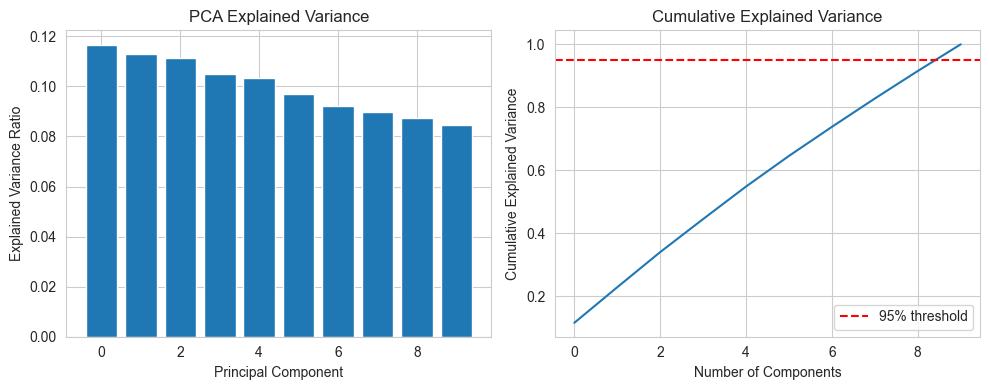

In [25]:
# Apply PCA to reduce noise
# Scale the data first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_noisy)

# Apply PCA keeping components that explain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_denoised_pca = pca.inverse_transform(X_pca)
X_denoised_pca = scaler.inverse_transform(X_denoised_pca)

print(f"Original features: {n_features}")
print(f"PCA components: {pca.n_components_}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

# Visualize explained variance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')

plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.legend()

plt.tight_layout()
plt.show()

### 4.2 Ensemble Methods for Robust Predictions

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_noisy, y_noisy, test_size=0.2, random_state=42
)

# Train Random Forest (inherently denoises through ensemble averaging)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Calculate true signal for test set
X_test_indices = X_test[:, :3]  # We know the first 3 features are important
y_true_signal = X_test_indices[:, 0] * 2 + X_test_indices[:, 1] * 1.5 + X_test_indices[:, 2] * 0.5

# Compare performance
mse_noisy = mean_squared_error(y_true_signal, y_test)
mse_rf = mean_squared_error(y_true_signal, y_pred_rf)

print(f"MSE (noisy data): {mse_noisy:.4f}")
print(f"MSE (Random Forest predictions): {mse_rf:.4f}")
print(f"Improvement: {(1 - mse_rf/mse_noisy) * 100:.2f}%")

MSE (noisy data): 1.8816
MSE (Random Forest predictions): 1.1317
Improvement: 39.86%


### 4.3 Anomaly Detection for Noise Removal

In [27]:
# Use Isolation Forest to detect and remove noisy samples
iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomaly_labels = iso_forest.fit_predict(X_train)

# Remove anomalies
X_train_clean = X_train[anomaly_labels == 1]
y_train_clean = y_train[anomaly_labels == 1]

print(f"Original training samples: {len(X_train)}")
print(f"Anomalies detected: {(anomaly_labels == -1).sum()}")
print(f"Clean training samples: {len(X_train_clean)}")

# Train model on cleaned data
rf_clean = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_clean.fit(X_train_clean, y_train_clean)
y_pred_clean = rf_clean.predict(X_test)

mse_clean = mean_squared_error(y_true_signal, y_pred_clean)
print(f"\nMSE (after anomaly removal): {mse_clean:.4f}")
print(f"Additional improvement: {(1 - mse_clean/mse_rf) * 100:.2f}%")

Original training samples: 400
Anomalies detected: 40
Clean training samples: 360

MSE (after anomaly removal): 0.9573
Additional improvement: 15.41%


### 4.4 Comparison Visualization

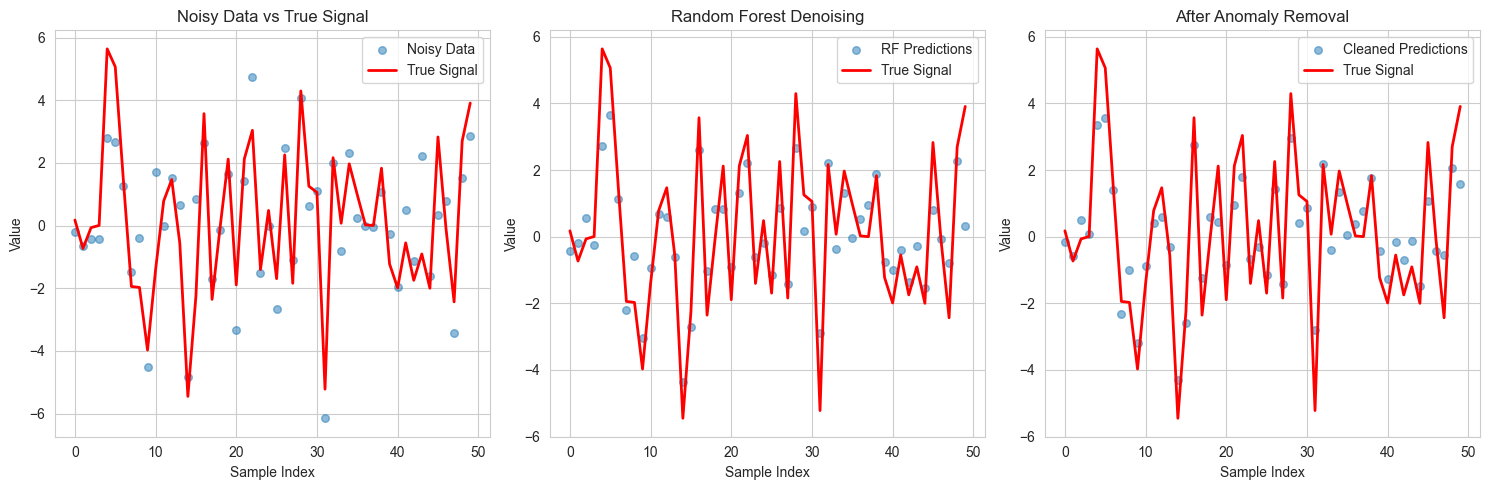

In [28]:
# Visualize denoising results
plt.figure(figsize=(15, 5))

# Plot 1: Noisy vs True Signal
plt.subplot(1, 3, 1)
sample_indices = range(50)
plt.scatter(sample_indices, y_test[sample_indices], alpha=0.5, label='Noisy Data', s=30)
plt.plot(sample_indices, y_true_signal[sample_indices], 'r-', linewidth=2, label='True Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Noisy Data vs True Signal')
plt.legend()

# Plot 2: Random Forest Predictions
plt.subplot(1, 3, 2)
plt.scatter(sample_indices, y_pred_rf[sample_indices], alpha=0.5, label='RF Predictions', s=30)
plt.plot(sample_indices, y_true_signal[sample_indices], 'r-', linewidth=2, label='True Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Random Forest Denoising')
plt.legend()

# Plot 3: Cleaned Model Predictions
plt.subplot(1, 3, 3)
plt.scatter(sample_indices, y_pred_clean[sample_indices], alpha=0.5, label='Cleaned Predictions', s=30)
plt.plot(sample_indices, y_true_signal[sample_indices], 'r-', linewidth=2, label='True Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('After Anomaly Removal')
plt.legend()

plt.tight_layout()
plt.show()

## Summary

In this notebook, we covered advanced feature engineering techniques:

1. **Dealing with Dirty Data**: We learned how to handle duplicates, standardize text data, and detect/handle outliers using IQR, capping, and Isolation Forest.

2. **Feature Value Imputation**: We explored various imputation strategies including simple imputation (mean, median, mode), KNN imputation, and ML-based imputation using Random Forest.

3. **Engineered Features**: We created new features through:
   - Polynomial features
   - Interaction features
   - Ratio and difference features
   - Time-based features (cyclical encoding)
   - Aggregation features (rolling statistics)
   - Binning and discretization

4. **Denoising With ML Models**: We demonstrated denoising techniques using:
   - PCA for dimensionality reduction and noise filtering
   - Ensemble methods (Random Forest) for robust predictions
   - Anomaly detection (Isolation Forest) for noise removal

These techniques are essential for improving model performance and should be applied based on your specific dataset and problem domain.